In [10]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

from b42fd.validation.postprocess import PostProcessing

In [11]:
events_flight = {"phugoid" : 53*60+38,
                 "spm" : 58*60+39,
                 "dutchroll" : 60*60+10,
                 "ape_roll" : 57*60+12.5,
                 "ape_spiral" : 62*60+30}

pp = PostProcessing("data/flight_data/flight_data.json", events_flight)


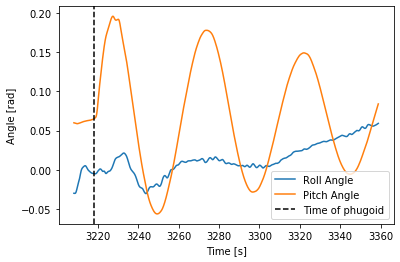

In [12]:
pp.plotAngles("phugoid", t_plot=141)

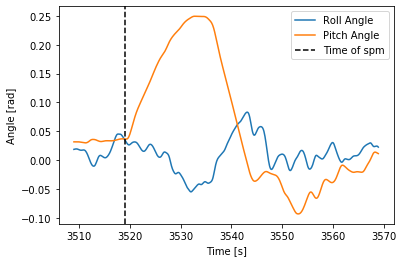

In [23]:
pp.plotAngles("spm", t_plot=50)

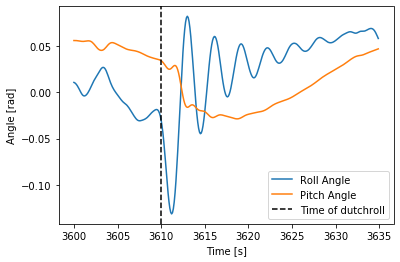

In [27]:
pp.plotAngles("dutchroll", t_plot=25)

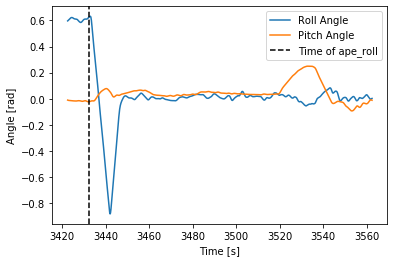

In [28]:
pp.plotAngles("ape_roll", t_plot=130)

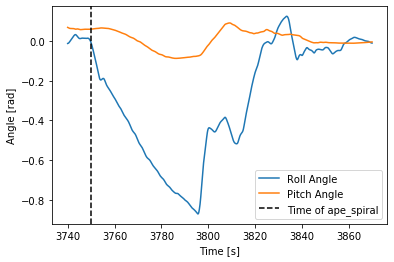

In [16]:
pp.plotAngles("ape_spiral", t_plot=120)

In [17]:
def getData(key_event,key_data, time):
        t_0 = pp.events[key_event] - 5
        t_0_i = np.searchsorted(pp.t, t_0)
        t_max = t_0 + time + 5
        t_max_i = np.searchsorted(pp.t, t_max)

        
        return np.array(pp.t[t_0_i:t_max_i]), np.array(pp.data[key_data]["data"][t_0_i:t_max_i])

Period = 47.59999999999991
Half time = 136.4486180542085


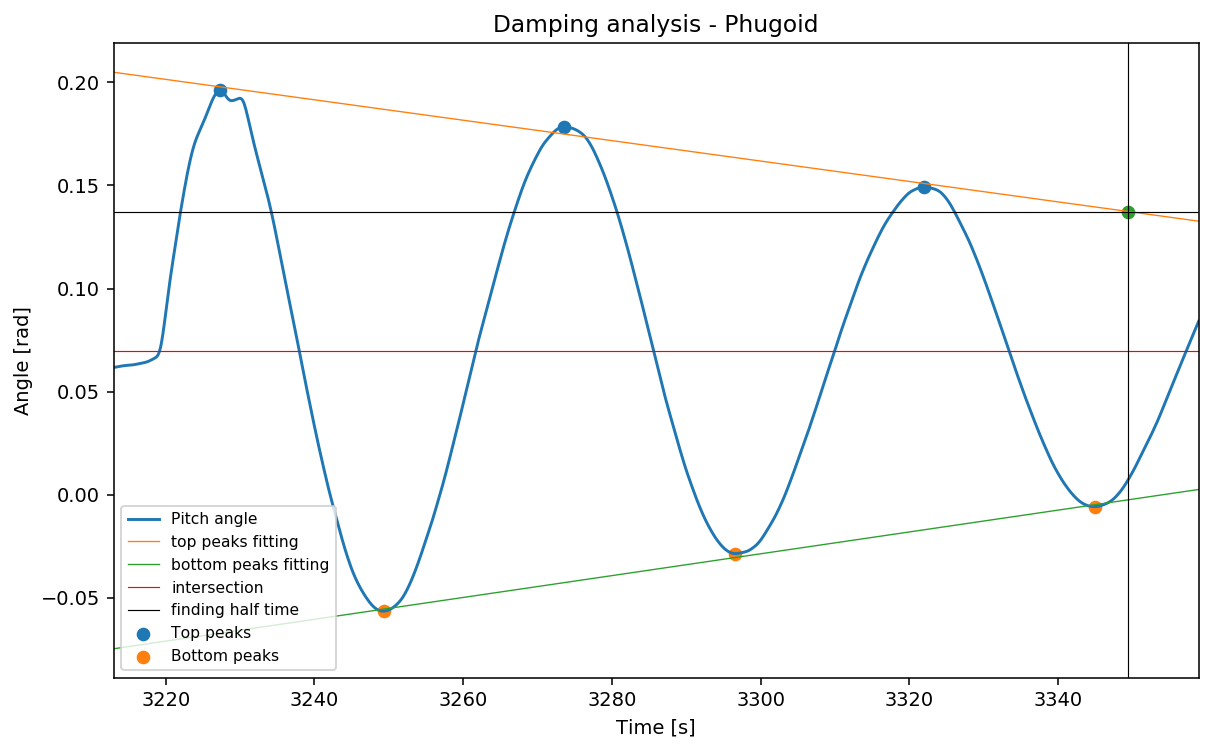

In [130]:
t, y = getData("phugoid", "Ahrs1_Pitch", 141)
peaks, _ = find_peaks(y, width=10)
peaks_inv, _ = find_peaks(-y, width=10)

top_y, top_x = [y[peak] for peak in peaks],  [t[peak] for peak in peaks]
bot_y, bot_x = [y[peak] for peak in peaks_inv], [t[peak] for peak in peaks_inv]

#find period
P = np.average(np.diff(np.stack((top_x, bot_x))))

# find half time
a, c = np.polyfit(top_x, top_y, deg=1)
b, d = np.polyfit(bot_x, bot_y, deg=1)

y_intersec = a*(d-c)/(a-b) + c

a_0 = a*t[0]+c
a_half = (a_0 - y_intersec)/2 + y_intersec


T_half = (a_half - c)/a - t[0]

print(f"Period = {P}\nHalf time = {T_half}")

plt.figure(figsize=(10,6), dpi=140)
plt.title("Damping analysis - Phugoid")

plt.plot(t,y, label="Pitch angle")
plt.plot(t, a*t+c, label="top peaks fitting", linewidth=0.7)
plt.plot(t, b*t+d, label="bottom peaks fitting", linewidth=0.7)

plt.axhline(y=y_intersec, c="red", label="intersection", linewidth=0.6)


plt.axhline(y=a_half, c="black", linewidth=0.6, label="finding half time")
plt.axvline(x=T_half+t[0], c="black", linewidth=0.6)

plt.scatter(top_x, top_y, label="Top peaks")
plt.scatter(bot_x, bot_y, label="Bottom peaks")
plt.scatter(T_half+t[0], a_half)

plt.legend(fontsize=8, loc="lower left")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")

plt.xlim([t[0], t[-1]])
plt.savefig("damping_phugoid.png")



3.019999999999982
Period = 3.019999999999982
Half time = 3.699999999999818


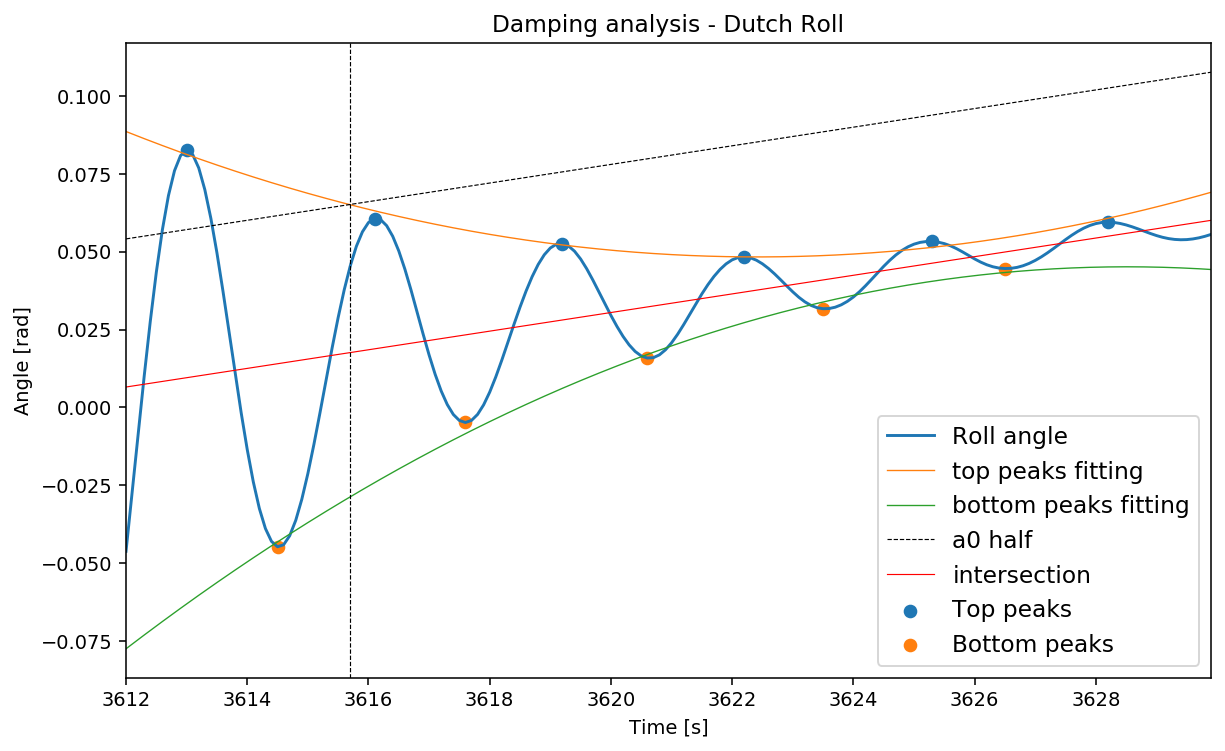

In [131]:
t, y = getData("dutchroll", "Ahrs1_Roll", 20)
t_0_i = np.searchsorted(t, 3612)
t = t[t_0_i:]
y = y[t_0_i:]

peaks, _ = find_peaks(y, width=10)
peaks_inv, _ = find_peaks(-y, width=10)

top_y, top_x = [y[peak] for peak in peaks],  [t[peak] for peak in peaks]
bot_y, bot_x = [y[peak] for peak in peaks_inv], [t[peak] for peak in peaks_inv]

#find period
P = np.average((np.average(np.diff(top_x)), np.average(np.diff(bot_x))))
print(P)
# find half time
a, b, c = np.polyfit(top_x, top_y, deg=2)
d, e, f = np.polyfit(bot_x, bot_y, deg=2)

top_line = a*t**2 + b*t +c
bot_line = d*t**2 + e*t +f

mid_0= np.average((a*t[0]**2 + b*t[0] + c, d*t[0]**2+e*t[0]+f))
mid_1= np.average((a*t[-1]**2 + b*t[-1] + c, d*t[-1]**2+e*t[-1]+f))

closest_i = np.abs(top_line - bot_line).argmin()
closest = np.average((a*t[closest_i]**2 + b*t[closest_i] + c, d*t[closest_i]**2+e*t[closest_i]+f))+0.005

p1_mid, p0_mid = np.polyfit((t[0], t[closest_i], t[-1]), (mid_0,closest, mid_1), deg=1)
y_intersec = p1_mid*t+p0_mid

a0 = top_line[0]-y_intersec[0]
a0_half = a0/2+y_intersec[0]


t_half_i = np.abs(top_line - (y_intersec+ a0_half)).argmin()
T_half = t[t_half_i]


print(f"Period = {P}\nHalf time = {T_half-t[0]}")

plt.figure(figsize=(10,6), dpi=140)

plt.title("Damping analysis - Dutch Roll")
plt.plot(t,y, label="Roll angle")
plt.plot(t,top_line , label="top peaks fitting",linewidth=0.7)
plt.plot(t,bot_line , label="bottom peaks fitting", linewidth=0.7)

plt.plot(t, y_intersec+a0_half, c="black", label="a0 half", linestyle="dashed", linewidth=0.6)

plt.plot(t, y_intersec, c="red", label="intersection", linewidth=0.6)

plt.axvline(x=T_half, c="black", linestyle="dashed",linewidth=0.6)

plt.scatter(top_x, top_y, label="Top peaks")
plt.scatter(bot_x, bot_y, label="Bottom peaks")
plt.scatter(T_half+t[0], a0_half)

plt.legend(fontsize=12)
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")

plt.xlim([t[0], t[-1]])
plt.savefig("damping_dutchroll.png")



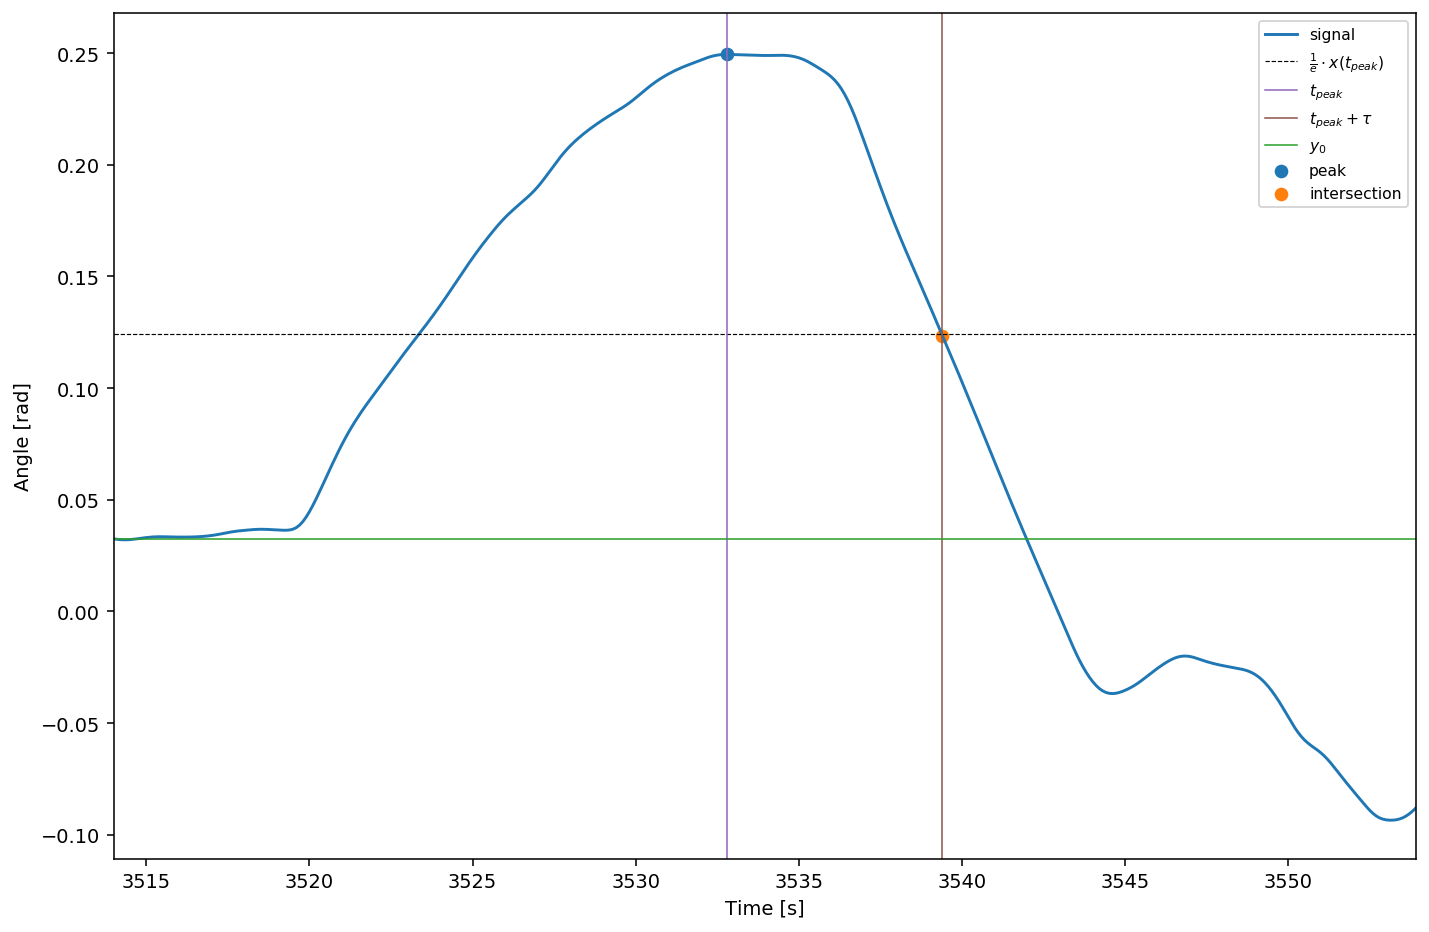

Tau = 6.599999999999454


In [119]:
t, y = getData("spm", "Ahrs1_Pitch", 35)


idx = y.argmax()
y_peak = y[idx]
y_0 = y[0]
t_peak = t[idx]

y_factor = 1/np.e * y[idx] + y_0

idx_closest = idx + np.abs(y[idx:]-y_factor).argmin()
tau = t[idx_closest] - t_0

plt.figure(figsize=(10,6), dpi=140)
plt.title("Damping analysis - Short Period Motion")

plt.plot(t,y, label="signal")
plt.scatter(t_peak, y_peak, label="peak")
plt.axhline(y=y_factor, c="black", label=r'$\frac{1}{e}\cdot x(t_{peak})$', linestyle="dashed", linewidth=0.6)
plt.axvline(x=t_peak, c="C4", linewidth=0.8, label=r"$t_{peak}$")
plt.axvline(x=t_peak+tau, c="C5", linewidth=0.8, label=r"$t_{peak} + \tau $")
plt.axhline(y=y_0, c="C2", label="$y_0$", linewidth=0.8)
plt.scatter(t[idx_closest], y[idx_closest], label="intersection")


plt.legend(fontsize=8)
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")

plt.xlim([t[0], t[-1]])
plt.show()

print(f"Tau = {tau}")
